In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
from torch.utils.data import DataLoader, SequentialSampler
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import classification_report, f1_score, accuracy_score
import pandas as pd
import ast

In [ ]:
test_data=torch.load('/content/drive/My Drive/tensor data/test_data.pt', weights_only=False)

Loading the test tensor dataset.

In [ ]:
batch_size=64

test_sampler=SequentialSampler(test_data)
test_dataloader=DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

Creating test dataloader with sequential sampler to ensure reproducibility.

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("thomas-sounack/BioClinical-ModernBERT-base", num_labels=14)
model.cuda()

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at thomas-sounack/BioClinical-ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ModernBertForSequenceClassification(
  (model): ModernBertModel(
    (embeddings): ModernBertEmbeddings(
      (tok_embeddings): Embedding(50368, 768, padding_idx=50283)
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (layers): ModuleList(
      (0): ModernBertEncoderLayer(
        (attn_norm): Identity()
        (attn): ModernBertAttention(
          (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
          (rotary_emb): ModernBertRotaryEmbedding()
          (Wo): Linear(in_features=768, out_features=768, bias=False)
          (out_drop): Identity()
        )
        (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): ModernBertMLP(
          (Wi): Linear(in_features=768, out_features=2304, bias=False)
          (act): GELUActivation()
          (drop): Dropout(p=0.0, inplace=False)
          (Wo): Linear(in_features=1152, out_features=768, bias=False)
        )
      

Loading the model and moving to GPU for processing.

In [ ]:
checkpoint=torch.load('/content/drive/My Drive/checkpoints/epoch_6.pt')

model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Loading the latest checkpoint and getting the model state dictionary for evaluation.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Setting the device to GPU

In [ ]:
model.eval()

#track variables
logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

# Predict
for i, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, = batch
    with torch.no_grad():
        # Forward pass
        outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        b_logit_pred = outs[0]
        pred_label = torch.sigmoid(b_logit_pred)

        b_logit_pred = b_logit_pred.detach().cpu().numpy()
        pred_label = pred_label.to('cpu').numpy()
        b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

# Flatten outputs
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]
# Converting flattened binary values to boolean values
true_bools = [tl==1 for tl in true_labels]

Evaluation of the model on test dataset in batches using the test dataloader.
Predicted probabilities are obtained using the sigmoid function.
True labels and predicted probabilites are converted to single lists (from nested lists) for further evaluation.

In [ ]:
pred_bools = [pl>0.50 for pl in pred_labels] #boolean output after thresholding
# Print and save classification report
Test_F1_Accuracy=f1_score(true_bools, pred_bools,average='micro')
Test_Flat_Accuracy= accuracy_score(true_bools, pred_bools)
print('Test F1 Accuracy: ',Test_F1_Accuracy )
print('Test Flat Accuracy: ',Test_Flat_Accuracy,'\n')

df_test=pd.DataFrame({'Test F1 Accuracy':Test_F1_Accuracy, 'Test Flat Accuracy':Test_Flat_Accuracy},index=[0])

print(classification_report(true_bools,pred_bools,target_names=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'Z']))
clf_report = classification_report(true_bools,pred_bools,target_names=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'Z'],output_dict=True)
df_report=pd.DataFrame(clf_report).transpose()

Test F1 Accuracy:  0.8517633465507733
Test Flat Accuracy:  0.16483405628972056 

              precision    recall  f1-score   support

           A       0.84      0.73      0.78      4730
           B       0.98      0.98      0.98      9324
           C       0.88      0.88      0.88      5201
           D       0.93      0.91      0.92      6257
           E       0.82      0.95      0.88      7835
           F       0.83      0.73      0.78      1765
           G       0.83      0.89      0.86      6776
           H       0.46      0.24      0.32      1189
           I       0.65      0.61      0.63      1085
           J       0.64      0.60      0.62      1098
           L       0.61      0.53      0.56      1476
           M       0.87      0.91      0.89      4223
           N       0.77      0.81      0.79      4481
           Z       0.73      0.73      0.73      1535

   micro avg       0.85      0.85      0.85     56975
   macro avg       0.78      0.75      0.76     56975

Predicted probabilites are converted into binary using a threshold of 0.5.
F1 score and accuracy are calculated.
More detailed classification report is calculated for each label and printed.

In [ ]:
df_report.to_csv('/content/drive/My Drive/Classification_Report.csv',index=False)

Saving the report as a csv file in Google Drive

In [ ]:
df_acc=pd.DataFrame({'True Labels':true_bools, 'Pred Labels':pred_bools})
df_acc.head()

,True Labels,Pred Labels
0,"[True, True, True, True, True, False, True, Fa...","[True, True, True, True, True, False, True, Fa..."
1,"[False, True, False, False, False, False, Fals...","[False, True, False, False, True, True, False,..."
2,"[True, True, True, True, True, True, True, Fal...","[True, True, True, False, True, True, True, Fa..."
3,"[True, True, False, False, True, False, True, ...","[True, True, True, False, True, False, True, F..."
4,"[True, True, False, True, True, False, False, ...","[True, True, True, True, True, False, False, F..."


Creating a dataframe with true labels and pred labels (from boolean values) to calculate Jaccard index.

In [ ]:
def multi_label_accuracy(df, true_labels_col, predicted_labels_col):

    accuracies = []
    for index, row in df.iterrows():
        true_label = row[true_labels_col]
        predicted_labels = row[predicted_labels_col]

        tp = 0
        fp = 0
        fn = 0

        for i in range(len(true_label)):
            t = true_label[i]
            p = predicted_labels[i]

            if t == 1 and p == 1:
                tp += 1
            elif t == 0 and p == 1:
                fp += 1
            elif t == 1 and p == 0:
                fn += 1

        denominator = tp + fp + fn
        if denominator > 0:
            accuracy = tp / denominator
            accuracies.append(accuracy)

    return sum(accuracies) / len(accuracies) if accuracies else 0.0

accuracy = multi_label_accuracy(df_acc, 'True Labels', 'Pred Labels')
print(f"Multi-label Accuracy: {accuracy}")

Multi-label Accuracy: 0.7510370507016317


Calculating the Jaccard index.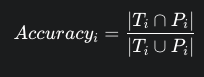
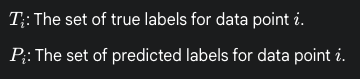